# Predict the Young's Modulus from surface maps
1. Only the original height distribution is known
2. Height distribution will ve related linearly with a predefined range of E-values
3. A synthetic map of 'real values is then created'
4. This map is downsized from (N, N) to (n, n)
5. n x n curves are chosen from experimental dataset, based on their E values (for each E in the map, the curve in the experimental dataset with the closest E is chosen)
6. Each curve goes as an input to our model and a final map with the error contour is plotted (E_matrix_map -> input_vector -> output_vector -> E_matrix_map_pred)


In [1]:
# Math and Dataframes
import h5py
import numpy as np
import pandas as pd
import scipy.io
import os

from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

In [3]:
# parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface'
parent_dir = os.getcwd()

# directory with .mat files
surf_map_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\mySurfGenApp' 
os.chdir(surf_map_dir)
target_file = h5py.File('analysis_results.mat', 'r')
os.chdir(parent_dir)

OSError: Unable to open file (file signature not found)

In [ ]:
variable_names = list(target_file.keys())
variable_names

['#refs#',
 'HPD',
 'HPDc',
 'HRc',
 'PSD',
 'PSDs',
 'X',
 'Y',
 'Z',
 'maxq',
 'minq',
 'params',
 'qs',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7']

In [ ]:
X = target_file['X'][()]
Y = target_file['Y'][()]
Z = target_file['Z'][()]
X.shape, Y.shape, Z.shape

OSError: Can't read data (inflate() failed)

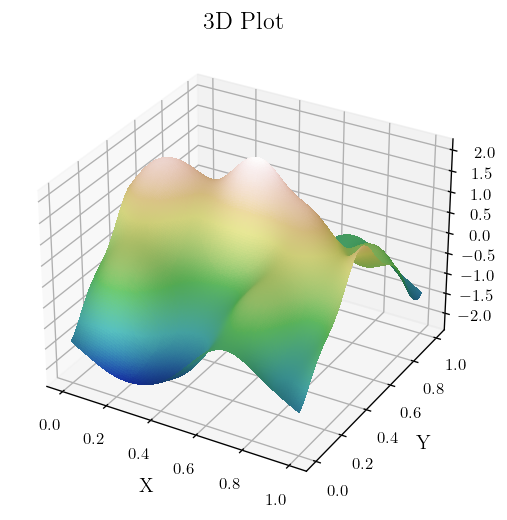

In [ ]:
# Create a 3D figure
fig = plt.figure(figsize=(10, 5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ls = LightSource(270, 45)
rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot')

# Show the plot
plt.show()

In [4]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    # JKR force formula in (3)
    E_eff = E / (1 - nu**2)
    K = 4/3*E_eff
    Ua = np.sqrt(6*np.pi*gamma)
    force = K * r **0.5 * i**1.5 - Ua * K ** 0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

Text(0.4, 10, '$\\uparrow E$')

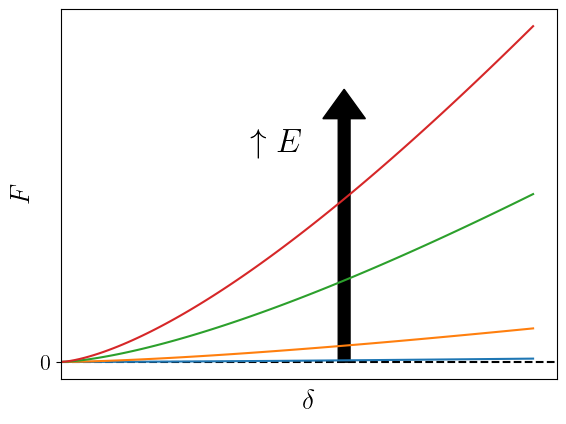

In [ ]:
# Hertz plots
E1 = .1
E2 = 1
E3 = 5
E4 = 10
i = np.linspace(0,1,100)
r = 1
nu = 0.5
plt.figure()
plt.xlim(xmin=0, xmax=1.05)
plt.xticks([])
plt.yticks([0], fontsize=16)
plt.hlines(0, 0, 1.05, linestyles='--', colors='black')
plt.xlabel('$\delta$', fontsize=20)
plt.ylabel('$F$', fontsize=20)
plt.plot(i, hertz(i, E1, nu, r), label=f'E = {E1}')
plt.plot(i, hertz(i, E2, nu, r), label=f'E = {E2}')
plt.plot(i, hertz(i, E3, nu, r), label=f'E = {E3}')
plt.plot(i, hertz(i, E4, nu, r), label=f'E = {E4}')
# plt.legend(fontsize=14)
plt.arrow(0.6, -0.01, 0, 13, length_includes_head=True, width=0.025,
          head_width=0.09, head_length=1.4, color='black')
plt.text(0.4,10,r'$\uparrow E$', fontsize=24,  bbox={'facecolor': 'white', 'alpha': 0, 'pad': 8, 'edgecolor':'black'}, color='black')
# plt.savefig('hertz_plot.pdf')


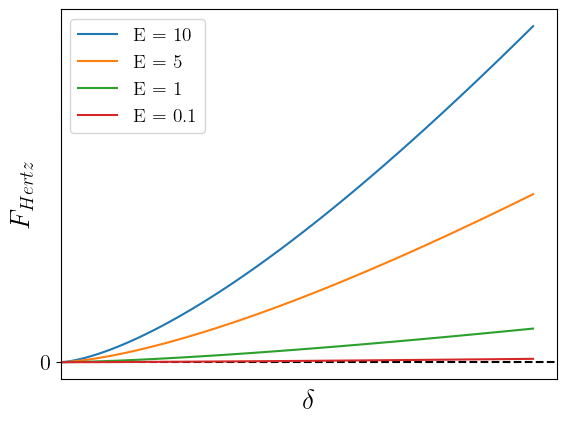

In [5]:
# Hertz plots
E1 = .1
E2 = 1
E3 = 5
E4 = 10
i = np.linspace(0,1,100)
r = 1
nu = 0.5
plt.figure()
plt.xlim(xmin=0, xmax=1.05)
plt.xticks([])
plt.yticks([0], fontsize=16)
plt.hlines(0, 0, 1.05, linestyles='--', colors='black')
plt.xlabel('$\delta$', fontsize=20)
plt.ylabel('$F_{Hertz}$', fontsize=20)
plt.plot(i, hertz(i, E4, nu, r), label=f'E = {E4}')
plt.plot(i, hertz(i, E3, nu, r), label=f'E = {E3}')
plt.plot(i, hertz(i, E2, nu, r), label=f'E = {E2}')
plt.plot(i, hertz(i, E1, nu, r), label=f'E = {E1}')

plt.legend(fontsize=14)
plt.savefig('hertz_plot.pdf', bbox_inches='tight')

In [6]:
os.getcwd()

'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\mySurfGenApp'

Text(0.43, 1, '$\\downarrow \\gamma$')

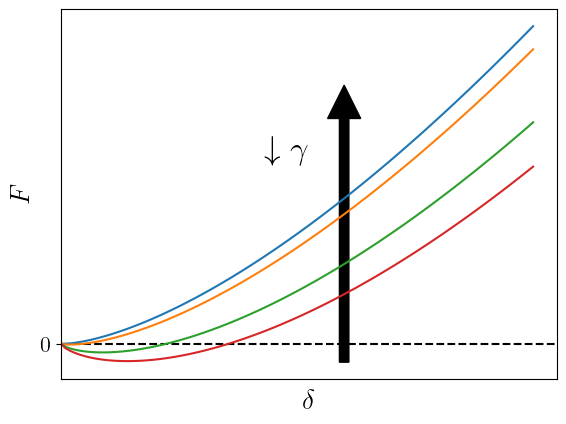

In [172]:
# Fixing gamma gives the same results as previous equation
E = 1

gamma1 = 0.0001
gamma2 = 0.001
gamma3 = 0.01
gamma4 = 0.02

arrow_x = 0.5
arrow_y_start = -0.01
arrow_y_end = -0.28

plt.figure()
plt.xlim(xmin=0, xmax=1.05)
plt.xticks([])
plt.yticks([0], fontsize=16)
plt.hlines(0, 0, 1.05, linestyles='--', colors='black')
plt.xlabel('$\delta$', fontsize=20)
plt.ylabel('$F$', fontsize=20)
plt.plot(i, jkr(i, E, nu, gamma1, r), label=r'$\uparrow$')
plt.plot(i, jkr(i, E, nu, gamma2, r), label=f'$\gamma$ = {gamma2}')
plt.plot(i, jkr(i, E, nu, gamma3, r), label=f'$\gamma$ = {gamma3}')
plt.plot(i, jkr(i, E, nu, gamma4, r), label=f'$\gamma$ = {gamma4}')
plt.arrow(0.6, -0.1, 0, 1.5, length_includes_head=True, width=0.02,
          head_width=0.07, head_length=0.18, color='black')
plt.text(0.43,1,r'$\downarrow \gamma$', fontsize=24,  bbox={'facecolor': 'white', 'alpha': 0, 'pad': 8, 'edgecolor':'black'}, color='black')
# plt.savefig('jkr_plot.pdf')

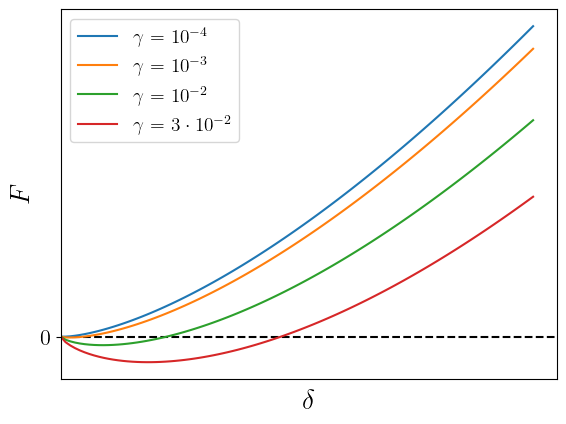

In [9]:
E = 1

gamma1 = 0.0001
gamma2 = 0.001
gamma3 = 0.01
gamma4 = 0.03

arrow_x = 0.5
arrow_y_start = -0.01
arrow_y_end = -0.28

plt.figure()
plt.xlim(xmin=0, xmax=1.05)
plt.xticks([])
plt.yticks([0], fontsize=16)
plt.hlines(0, 0, 1.05, linestyles='--', colors='black')
plt.xlabel('$\delta$', fontsize=20)
plt.ylabel('$F$', fontsize=20)
plt.plot(i, jkr(i, E, nu, gamma1, r), label='$\gamma$ = $10^{-4}$') # Confirmar os valores das labels
plt.plot(i, jkr(i, E, nu, gamma2, r), label='$\gamma$ = $10^{-3}$')
plt.plot(i, jkr(i, E, nu, gamma3, r), label='$\gamma$ = $10^{-2}$')
plt.plot(i, jkr(i, E, nu, gamma4, r), label='$\gamma$ = $3\cdot10^{-2}$')
plt.legend(fontsize=14)
plt.savefig('jkr_plot.pdf', bbox_inches='tight')

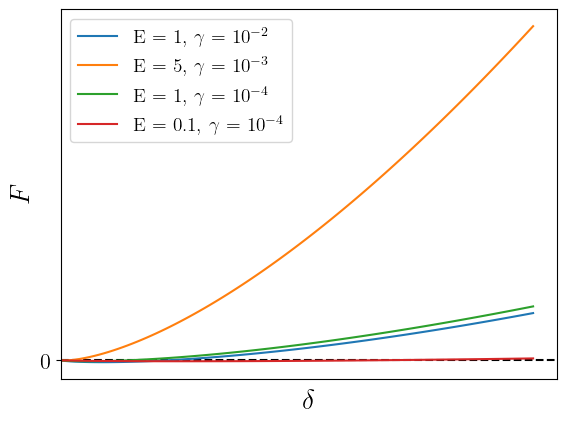

In [189]:
gamma = 0.005

E1 = .1
E2 = 1
E3 = 5
E4 = 10

gamma1 = 0.0001
gamma2 = 0.001
gamma3 = 0.01
gamma4 = 0.03

plt.figure()
plt.xlim(xmin=0, xmax=1.05)
plt.xticks([])
plt.yticks([0], fontsize=16)
plt.hlines(0, 0, 1.05, linestyles='--', colors='black')
plt.xlabel('$\delta$', fontsize=20)
plt.ylabel('$F$', fontsize=20)
plt.plot(i, jkr(i, E2, nu, gamma3, r), label=f'E = {E2}'', $\gamma$ = $10^{-2}$') # Confirmar os valores das labels
plt.plot(i, jkr(i, E3, nu, gamma2, r), label=f'E = {E3}'', $\gamma$ = $10^{-3}$')
plt.plot(i, jkr(i, E2, nu, gamma, r), label=f'E = {E2}'', $\gamma$ = $10^{-4}$')
plt.plot(i, jkr(i, E1, nu, gamma, r), label=f'E = {E1}'', $\gamma$ = $10^{-4}$')
plt.legend(fontsize=14)
# plt.savefig('jkr_plot.pdf')

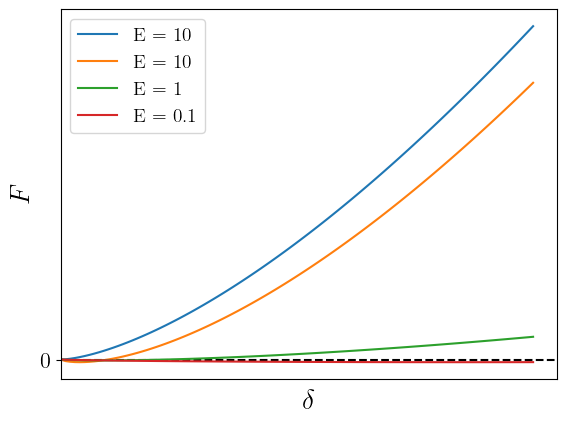

In [186]:
gamma = 0.005

E1 = .1
E2 = 1
E3 = 5
E4 = 10

plt.figure()
plt.xlim(xmin=0, xmax=1.05)
plt.xticks([])
plt.yticks([0], fontsize=16)
plt.hlines(0, 0, 1.05, linestyles='--', colors='black')
plt.xlabel('$\delta$', fontsize=20)
plt.ylabel('$F$', fontsize=20)
plt.plot(i, jkr(i, E4, nu, gamma1, r), label=f'E = {E4}') # Confirmar os valores das labels
plt.plot(i, jkr(i, E4, nu, gamma4, r), label=f'E = {E4}')
plt.plot(i, jkr(i, E2, nu, gamma3, r), label=f'E = {E2}')
plt.plot(i, jkr(i, E1, nu, gamma4, r), label=f'E = {E1}')
plt.legend(fontsize=14)
# plt.savefig('jkr_plot.pdf')

In [7]:
os.getcwd()

'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\mySurfGenApp'